In [33]:
import os
import shutil

import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import cantera as ct
import numpy as np
from numpy import genfromtxt
from numpy import savetxt

import random as rnd
import matplotlib.pyplot as plt
from scipy import integrate 

plt.rcParams.update({'font.size': 12})
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['xtick.labelsize'] = 2
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16

 
%matplotlib inline
from torchdiffeq import odeint_adjoint as odeint
device = 'cpu'

In [34]:
base_name = 'node_h2_v1' # Provide name of directory where model is stored
work_dir = os.getcwd()
validation_results = 'plots_' + base_name # Plots are saved in the work directory 
restart_id =2
isdir = os.path.isdir(validation_results) 

if isdir == False :
    os.makedirs(validation_results)
# else: 
#     shutil.rmtree(validation_results)
#     os.makedirs(validation_results)
    


In [35]:
# PMSR inputs

dt = 1.E-6           # step size for inlet/outlet/pairing
tau_r  = 1.0E-2     # reactor residence time
nsteps = int(tau_r / dt)

ntau_r = 5             # number of run times to simulate for
mech   = 'h2_sandiego.yaml'    # chemical mechanism

X0     = 'O2:1.0, N2:3.76'      # Oxidiser composition
X1     = 'H2:1.0'      # Fuel composition
P      = 101325.0

# eqr = np.linspace(0.5,1.5,5)
# T0     = (np.linspace(950,1200,6)).astype(int)
eqr = [0.1, 1.1, 0.5, 1.5 ,0.25 , 1.0, 0.75, 2.0, 0.9, 1.25]
T0 = [1200,1000,1100,1050,1150,950]

n_sim = len(eqr)*len(T0)


gas = ct.Solution(mech)
nspecies = np.size(gas.species())
species = gas.species()


In [36]:
ymax = genfromtxt(base_name+'/ymax_filter.csv', delimiter=',')
ymin = genfromtxt(base_name+'/ymin_filter.csv', delimiter=',')

def normalize(y):
    y = (y-ymin)/(ymax-ymin)   # Input Yis normalized to [0 1]
    np.clip(y, 0.0, 1.0) # Putting data bounds to ensure they are followed during inference
    return y

def denormalize(y): 
    # Denormalize the data
    y = y * (ymax - ymin) + ymin

    # Set negative values to zero
    y[y < 0] = 0 # Mixture fractions can not be negative

    # Ensure sum of species mass fractions is 1
    # Assuming y[:-3] contains the species - MF of N2 = 1-sum of MF of all other species (total sum need to be 1)
    # y[-2] = np.sum(1.0 - y[0:-3])
    return y


In [37]:
# need to be same as trained network
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(  
            
            nn.Linear(10, 150), #check the structure
            nn.ELU(inplace=True),
            
            
            nn.Linear(150, 150),
            nn.ELU(inplace=True),
            
            nn.Linear(150, 150),
            nn.ELU(inplace=True),

            nn.Linear(150, 10),  
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, val=0)
                nn.init.xavier_uniform_(m.weight, gain=np.sqrt(2))

    def forward(self, t, y):
        y = torch.tensor(y).float()
        t = torch.tensor(t).float()
        
        return self.net(y).detach().numpy()

#loading
os.chdir(base_name)
model_name = base_name + '_'+str(restart_id) +'.pt'
func = torch.load(model_name)
func.eval()
os.chdir(work_dir)


In [38]:
func

ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=150, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=150, out_features=150, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=150, out_features=10, bias=True)
  )
)

In [39]:
# Detailes kinetics from Cantera
def reaction_source(t,y_local) : # ylocal = [Yi,h]
    gas.Y = y_local[0:-1]
    gas.TP = y_local[-1], P
    wy = gas.net_production_rates * gas.molecular_weights / gas.density
    hm = gas.partial_molar_enthalpies/gas.molecular_weights
    wt = (-(np.sum(wy*hm)))/(gas.cp_mass)
    w = np.append(wy, wt)
    return w

class Lambda(nn.Module):

    def forward(self, t, y):
        w = reaction_source(t,y)
        return torch.tensor(w)
    
def ignition_delay(t, y):
    T = y[:,-1]
    idx = np.argmax(T>(T0[j]+400))
    return t[idx]



In [40]:
# gas.species()

In [41]:
from matplotlib.lines import Line2D

def export_legend(legend, filename, expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)
    
def plot_tempOH_species(t,my_data,norm_my_data,t_2,my_data_2,norm_my_data_2,filename):    
    fig, ax1 = plt.subplots() 
    
#     colors =  ['k','b','g', 'r', 'c', 'm', 'y']
    colors = [plt.cm.Set1(i) for i in range(20)]
    marker_size = 3
    
    clr = 'k'
    ax1.set_xlabel(r'Time (sec) ',fontsize=14)
    ax1.set_ylabel(r' T (K)',fontsize=14) 
    ax1.plot(t,my_data[:,-1],'-',color=clr, label = 'T-DKM')
    ax1.plot(t_2,my_data_2[:,-1],'^',color=clr,label = 'T-NODE',markersize=marker_size)
#     ax1.legend(loc='upper right')
    ax1.tick_params(axis ='y', labelcolor = clr)
    ax1.set_ylim([700,3000])
    
    # Adding Twin Axes to plot using dataset_2
    ax2 = ax1.twinx() 
    
    unfilled_markers = ['s','d','p','o','h']
    line_styles = ['-', '--', '-.', ':']
    major_sp = [0,2,3,5]
    a = 0
    sp = ['H2','O2','OH','H2O']
    for k in major_sp:
        if k==3:
            ax2.plot(t,norm_my_data[:,k], color = colors[a+1],linestyle=line_styles[a],
                 label = sp[a]+'-DKM')
            ax2.plot(t_2,norm_my_data_2[:,k],color = colors[a+1],marker=unfilled_markers[a],linestyle='',
                 label = sp[a]+'-NODE',markersize=marker_size)
        else:
            ax2.plot(t,norm_my_data[:,k], color = colors[a+1],linestyle=line_styles[a],
                     label = sp[a]+'-DKM')
            ax2.plot(t_2,norm_my_data_2[:,k] ,color = colors[a+1],marker=unfilled_markers[a],linestyle='',
                     label = sp[a]+'-NODE',markersize=marker_size)
        a=a+1
        
    color = 'black'
    ax2.set_ylabel('Normalized Species MF', color = color, fontsize = 16) 
    ax2.tick_params(axis ='y', labelcolor = color)
#     ax2.legend(loc='upper left')
    
    ax1.set_xscale('log')
    # ax1.set_xlim([1.0e-6,0.5e-2])
    ax2.set_ylim([-0.09,1.1])
    
#     ax1.grid(color = 'grey', linestyle = '--', linewidth = 0.5, axis='both', which='both')
#     ax2.grid(color = 'grey', linestyle = '--', linewidth = 0.5, axis='both', which='both')

    fig_name = validation_results + "/TempOH_ " + filename+'.png'
    fig.savefig(fig_name,dpi=200, bbox_inches='tight')
    
#     plt.show()
    legend_1 = ax1.legend(loc='right', bbox_to_anchor=(0.5,1.2), ncol=1,fontsize=14)
    legend_2 = ax2.legend(loc='lower center', bbox_to_anchor=(0.5, 1.5), ncol=4,fontsize=14)

    fig_name_2 = fig_name +'_with_legend.png'
    plt.savefig(fig_name_2, bbox_inches='tight',dpi=200)
    
    export_legend(legend_1,'leg_1')
    export_legend(legend_2,'leg_2')
    
    plt.show()
    


-----------start of simulation NN  1 --------------------------------------------------
Equivalence ration = 0.1, Temprature = 1200


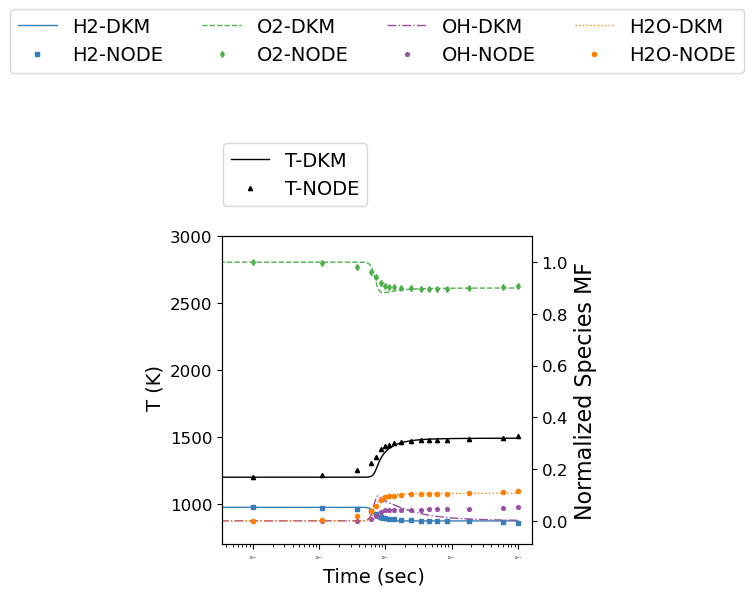

-----------start of simulation NN  2 --------------------------------------------------
Equivalence ration = 0.1, Temprature = 1000


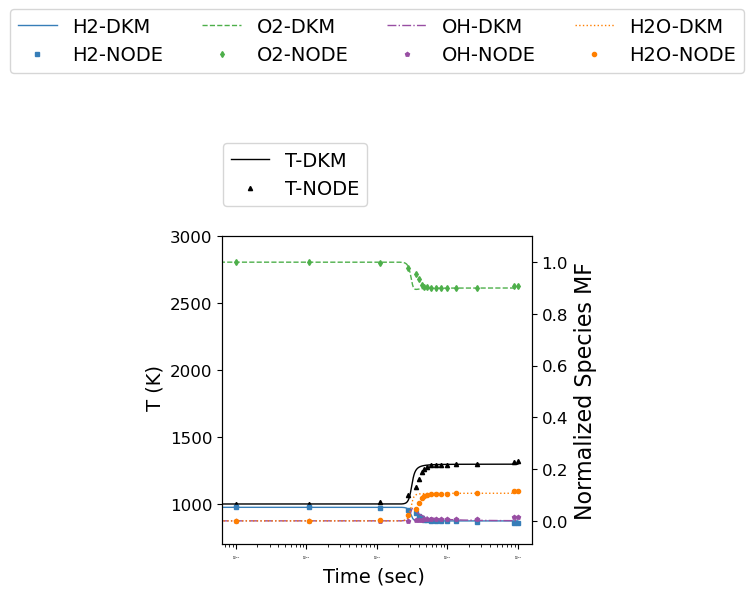

-----------start of simulation NN  3 --------------------------------------------------
Equivalence ration = 0.1, Temprature = 1100


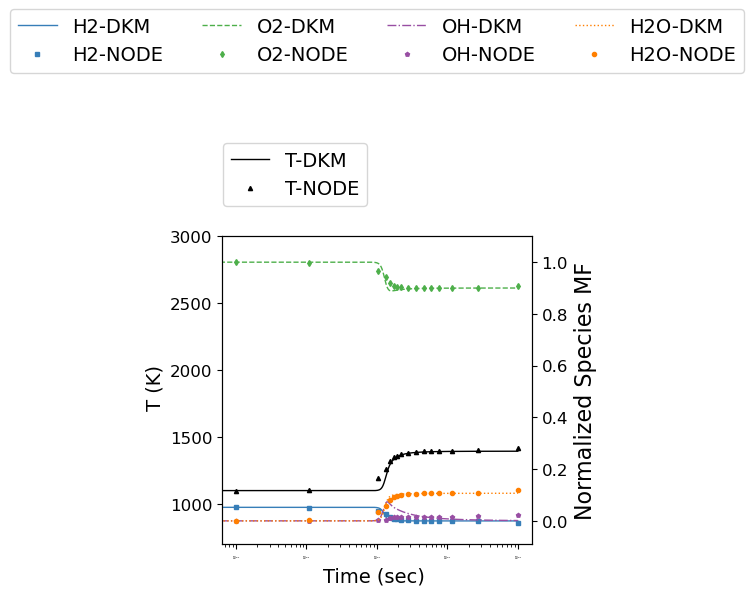

-----------start of simulation NN  4 --------------------------------------------------
Equivalence ration = 0.1, Temprature = 1050


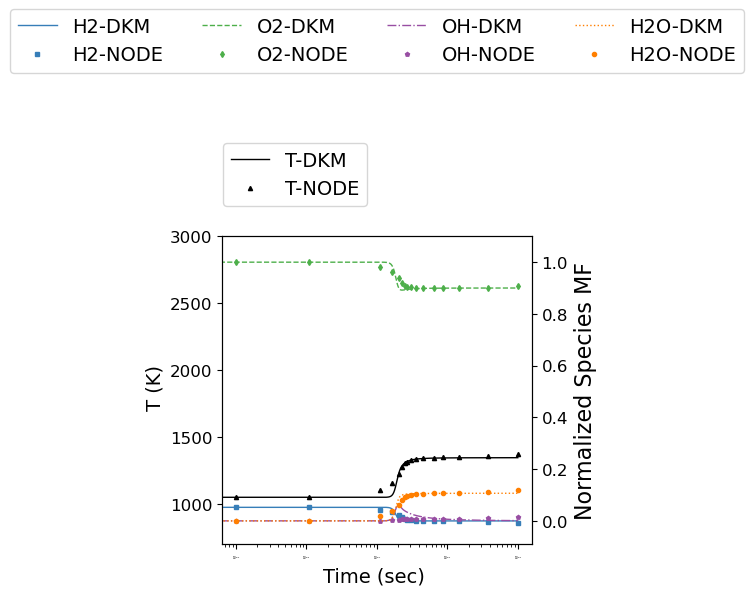

-----------start of simulation NN  5 --------------------------------------------------
Equivalence ration = 0.1, Temprature = 1150


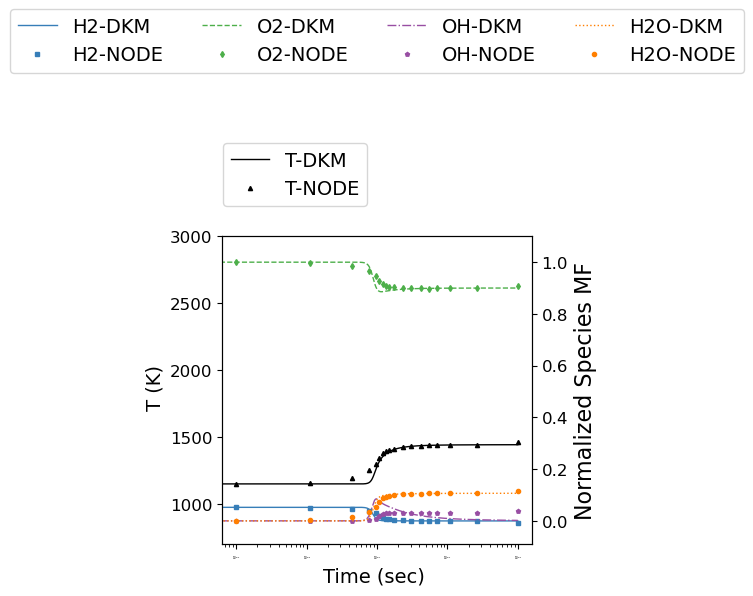

-----------start of simulation NN  6 --------------------------------------------------
Equivalence ration = 0.1, Temprature = 950


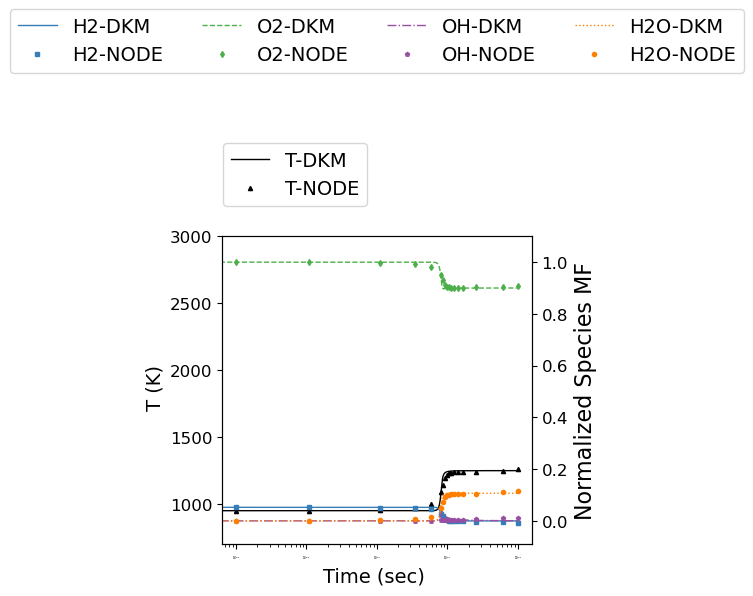

-----------start of simulation NN  2 --------------------------------------------------
Equivalence ration = 1.1, Temprature = 1200


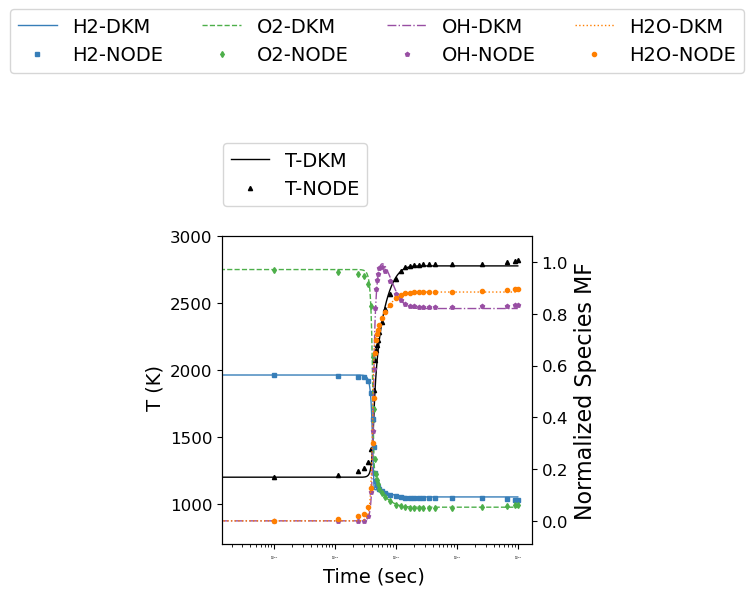

-----------start of simulation NN  3 --------------------------------------------------
Equivalence ration = 1.1, Temprature = 1000


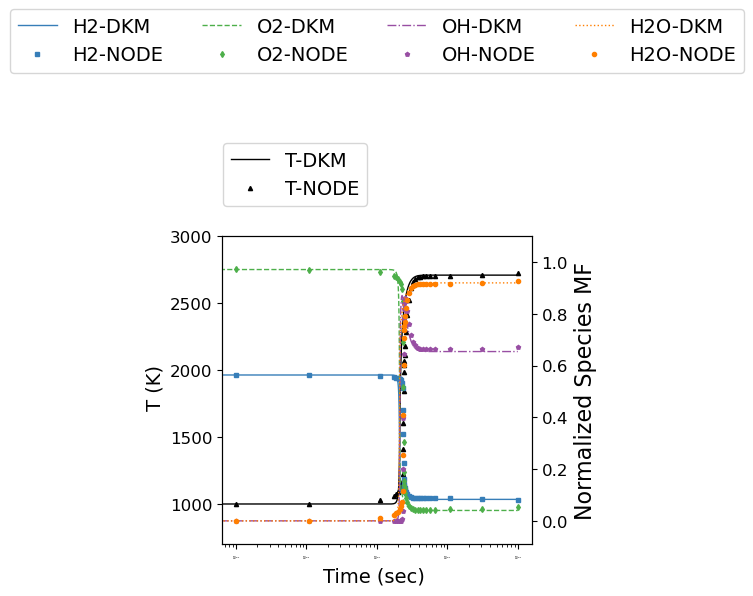

-----------start of simulation NN  4 --------------------------------------------------
Equivalence ration = 1.1, Temprature = 1100


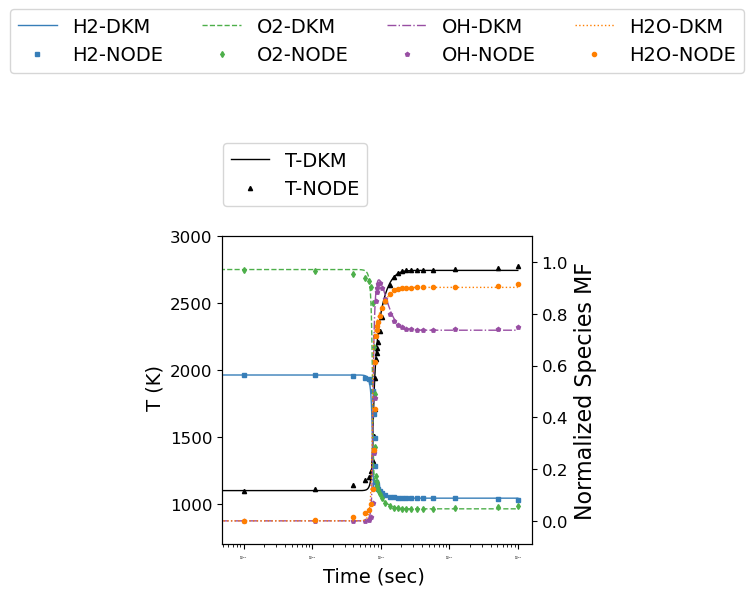

-----------start of simulation NN  5 --------------------------------------------------
Equivalence ration = 1.1, Temprature = 1050


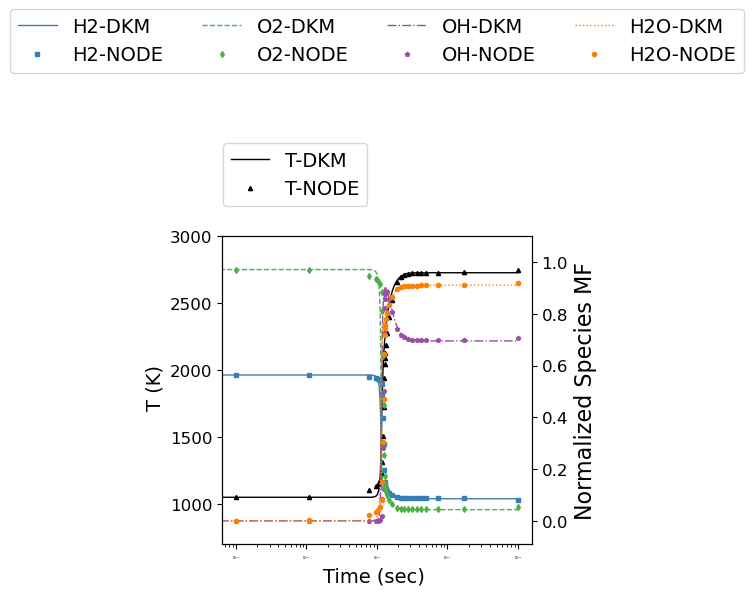

-----------start of simulation NN  6 --------------------------------------------------
Equivalence ration = 1.1, Temprature = 1150


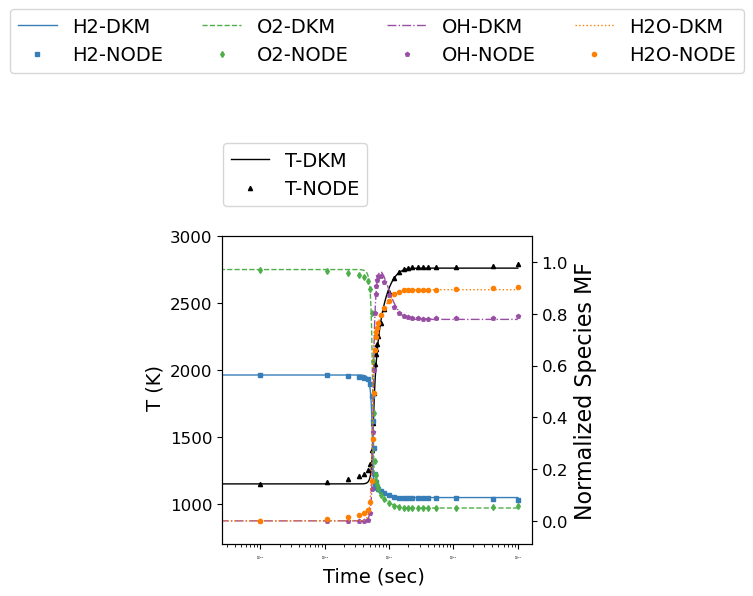

-----------start of simulation NN  7 --------------------------------------------------
Equivalence ration = 1.1, Temprature = 950


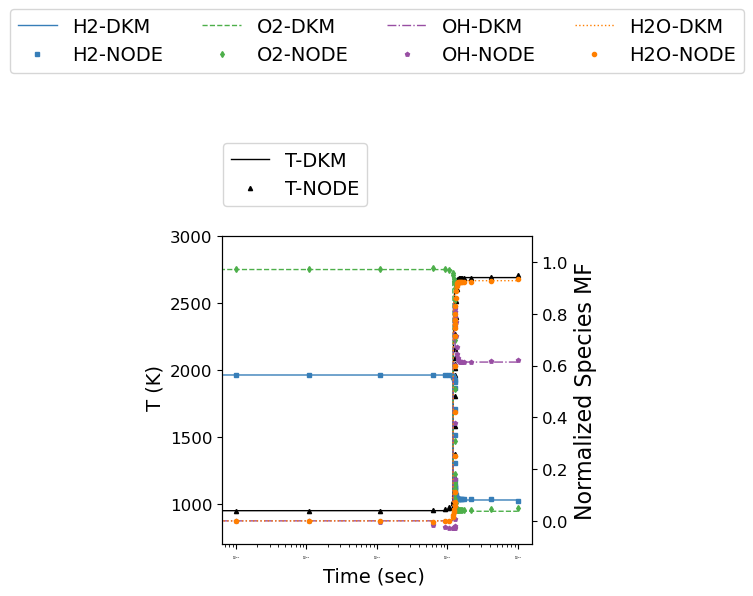

-----------start of simulation NN  3 --------------------------------------------------
Equivalence ration = 0.5, Temprature = 1200


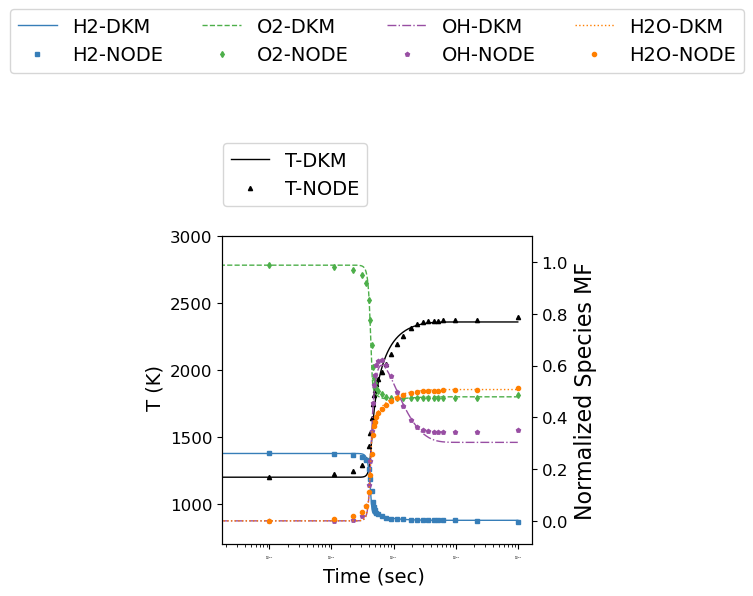

-----------start of simulation NN  4 --------------------------------------------------
Equivalence ration = 0.5, Temprature = 1000


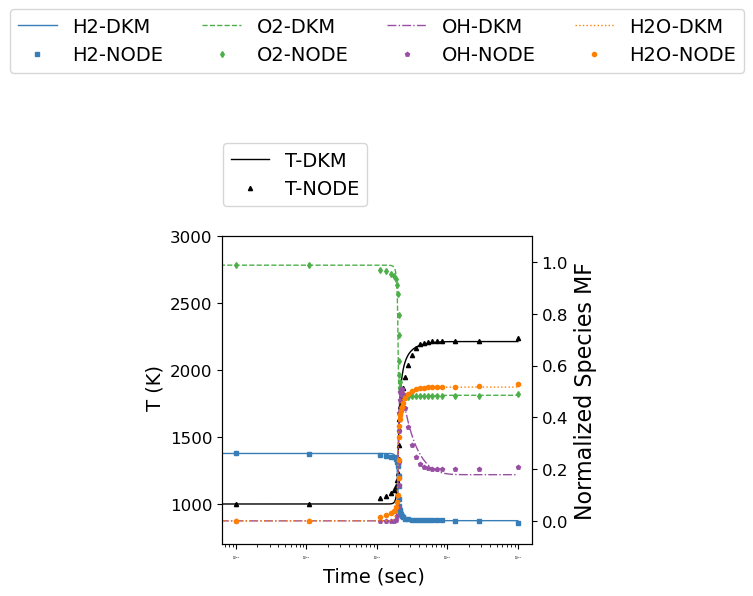

-----------start of simulation NN  5 --------------------------------------------------
Equivalence ration = 0.5, Temprature = 1100


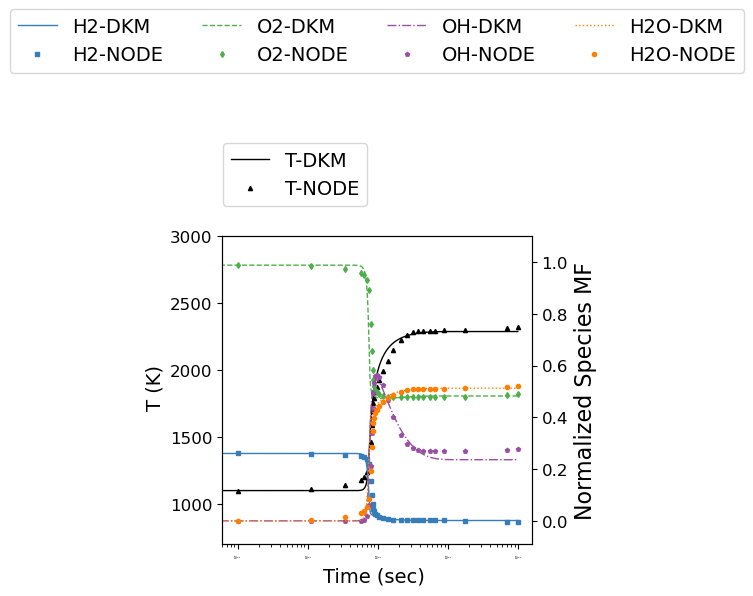

-----------start of simulation NN  6 --------------------------------------------------
Equivalence ration = 0.5, Temprature = 1050


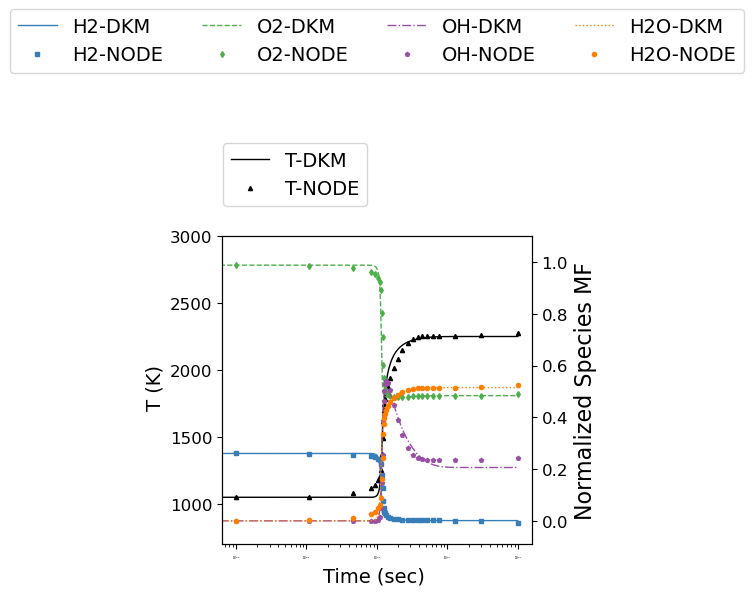

-----------start of simulation NN  7 --------------------------------------------------
Equivalence ration = 0.5, Temprature = 1150


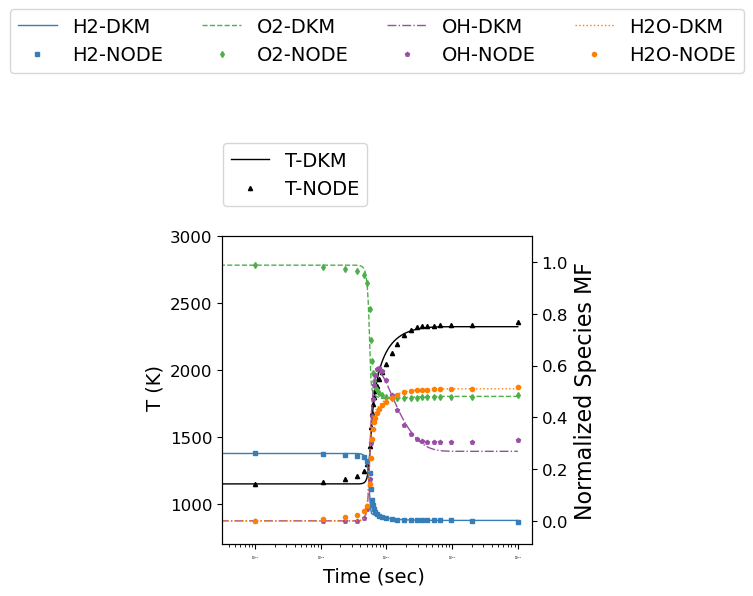

-----------start of simulation NN  8 --------------------------------------------------
Equivalence ration = 0.5, Temprature = 950


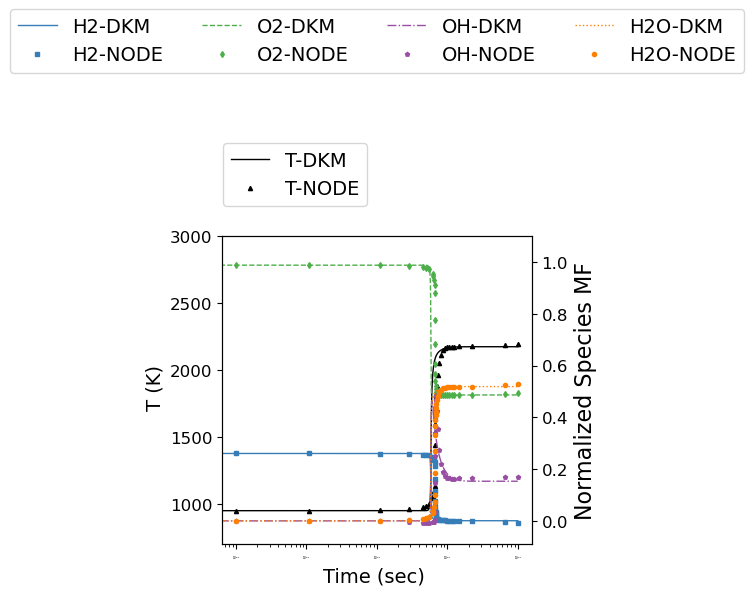

-----------start of simulation NN  4 --------------------------------------------------
Equivalence ration = 1.5, Temprature = 1200


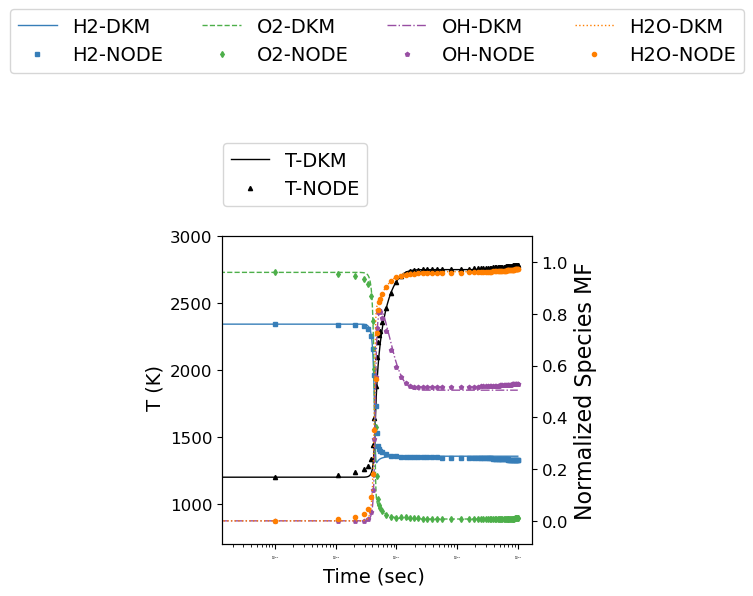

-----------start of simulation NN  5 --------------------------------------------------
Equivalence ration = 1.5, Temprature = 1000


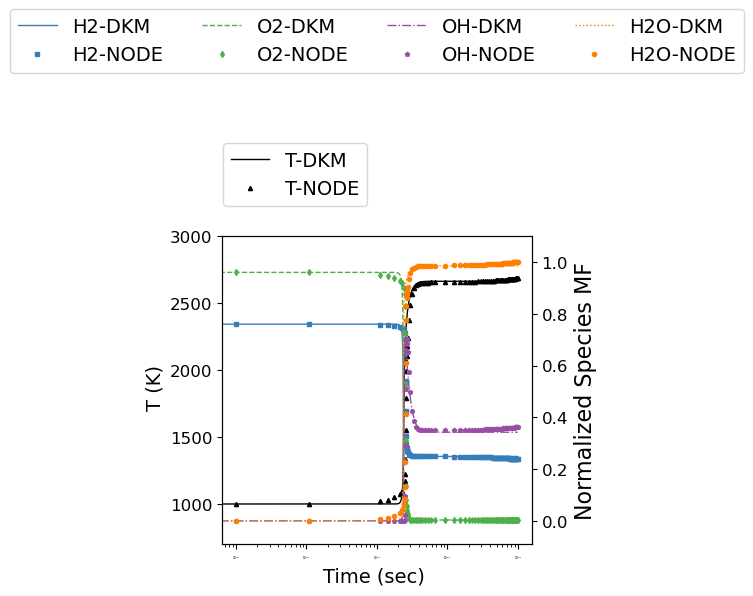

-----------start of simulation NN  6 --------------------------------------------------
Equivalence ration = 1.5, Temprature = 1100


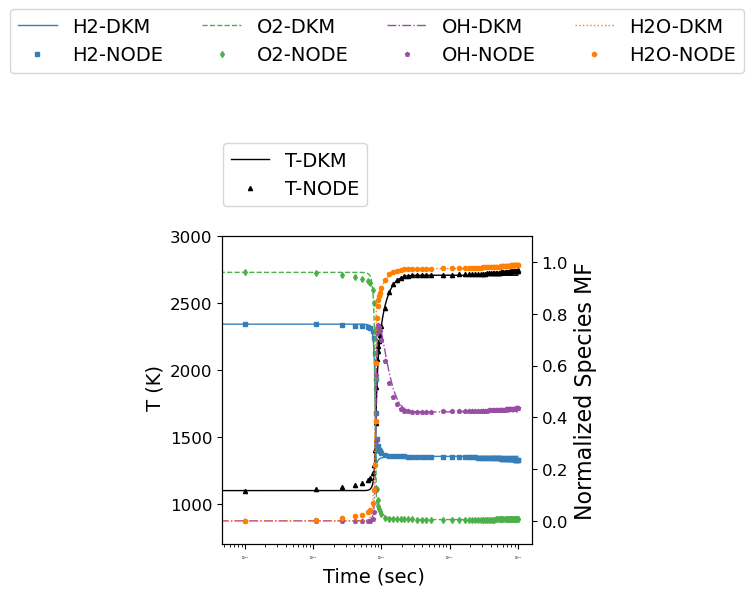

-----------start of simulation NN  7 --------------------------------------------------
Equivalence ration = 1.5, Temprature = 1050


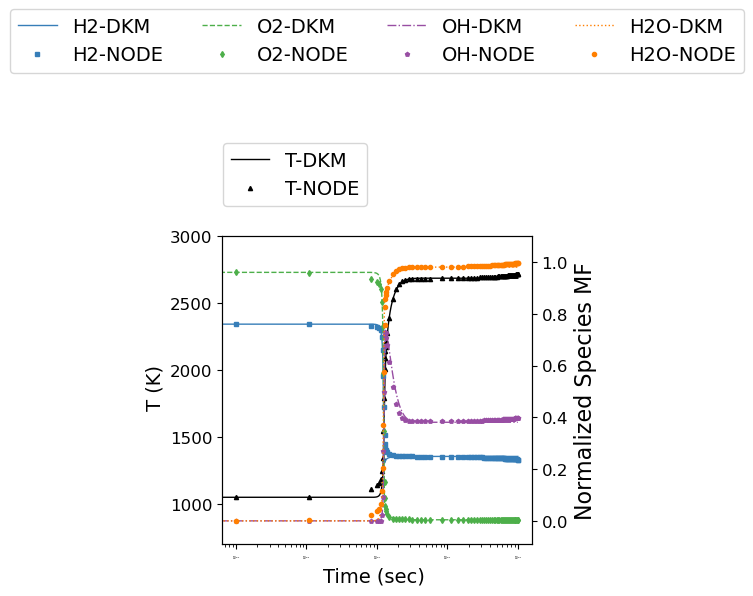

-----------start of simulation NN  8 --------------------------------------------------
Equivalence ration = 1.5, Temprature = 1150


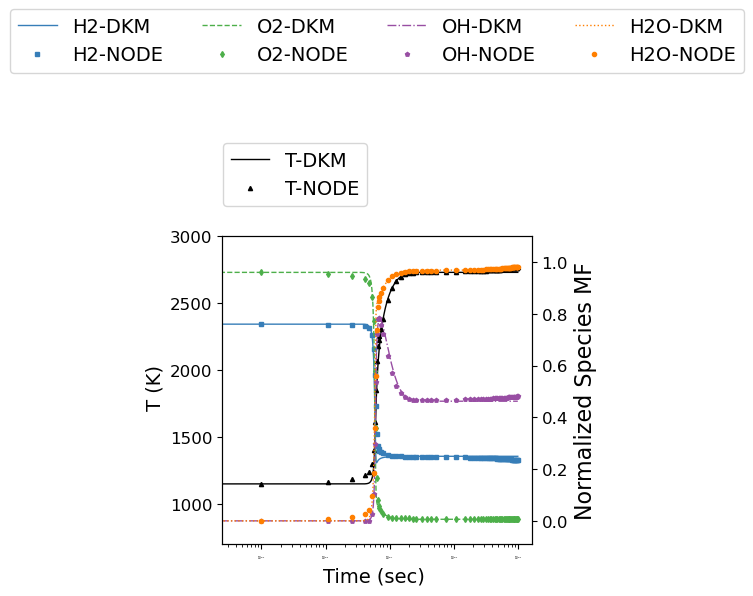

-----------start of simulation NN  9 --------------------------------------------------
Equivalence ration = 1.5, Temprature = 950


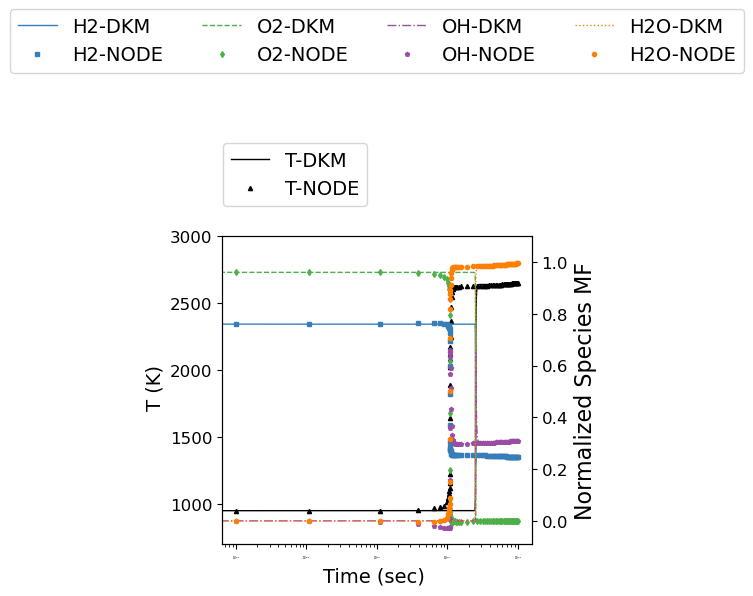

-----------start of simulation NN  5 --------------------------------------------------
Equivalence ration = 0.25, Temprature = 1200


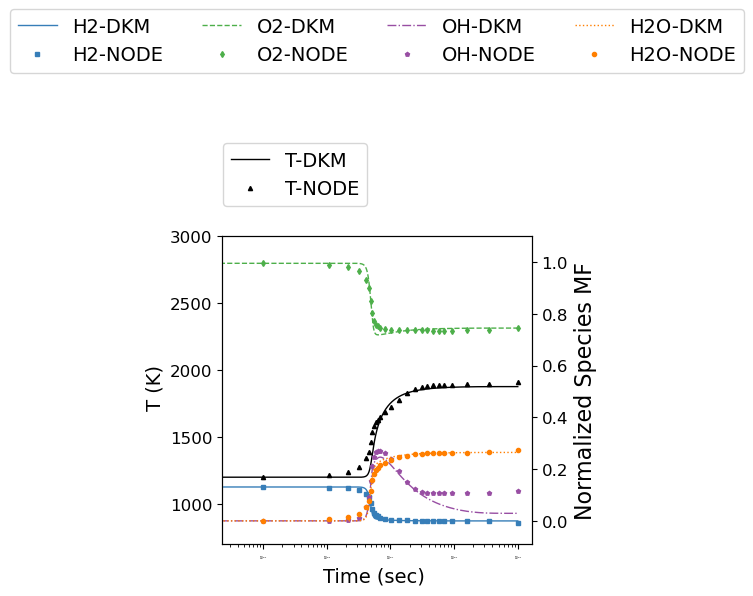

-----------start of simulation NN  6 --------------------------------------------------
Equivalence ration = 0.25, Temprature = 1000


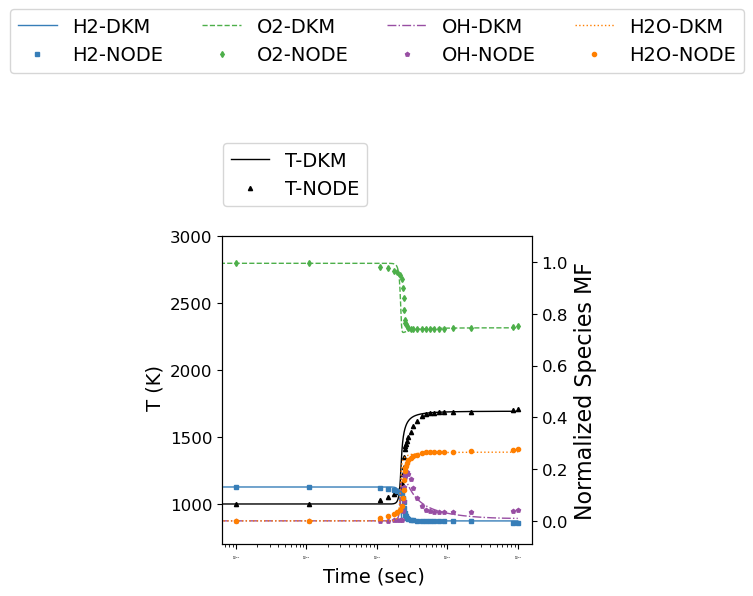

-----------start of simulation NN  7 --------------------------------------------------
Equivalence ration = 0.25, Temprature = 1100


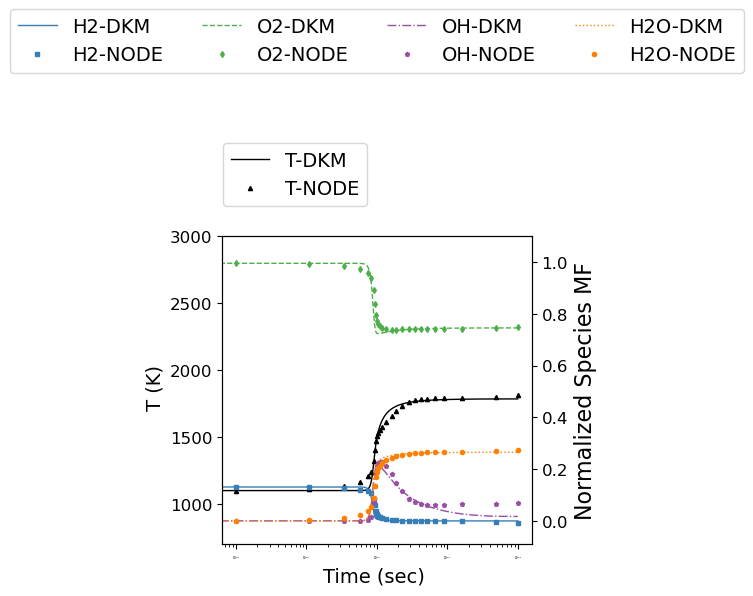

-----------start of simulation NN  8 --------------------------------------------------
Equivalence ration = 0.25, Temprature = 1050


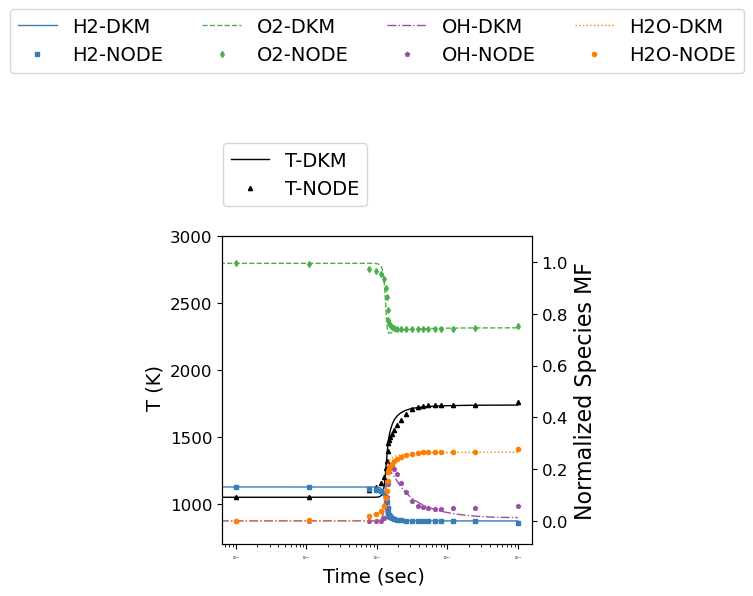

-----------start of simulation NN  9 --------------------------------------------------
Equivalence ration = 0.25, Temprature = 1150


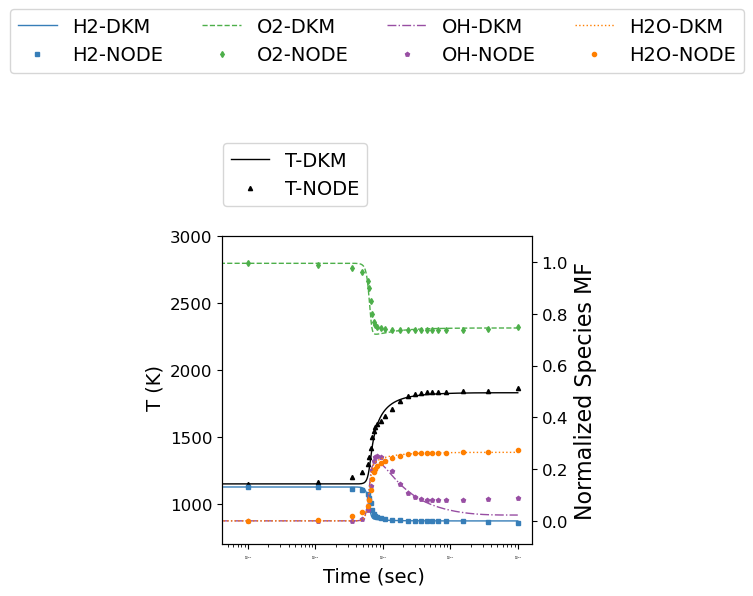

-----------start of simulation NN  10 --------------------------------------------------
Equivalence ration = 0.25, Temprature = 950


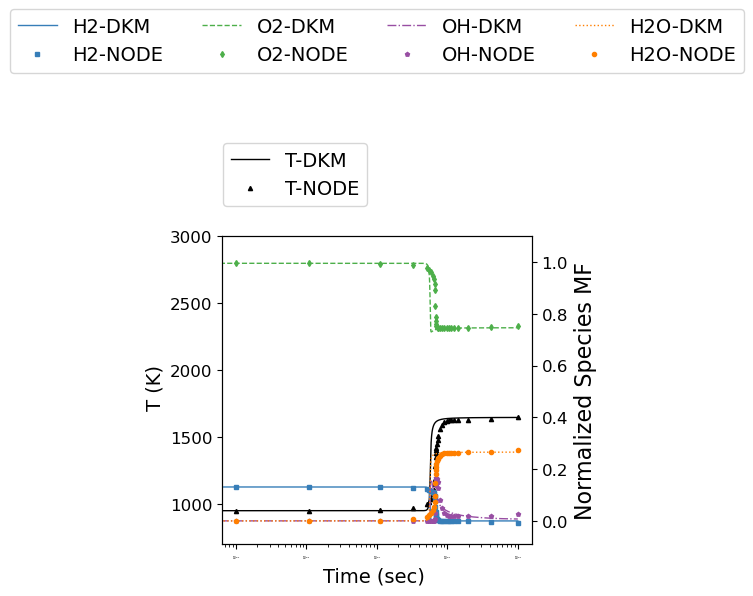

-----------start of simulation NN  6 --------------------------------------------------
Equivalence ration = 1.0, Temprature = 1200


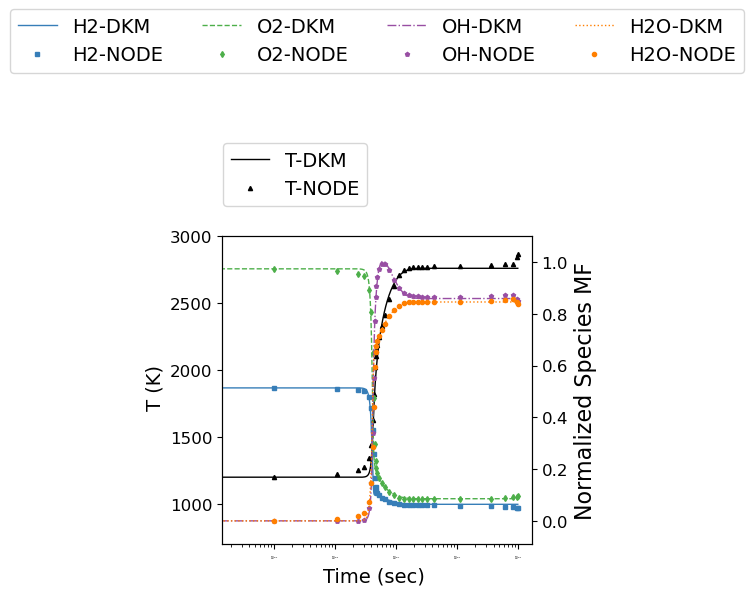

-----------start of simulation NN  7 --------------------------------------------------
Equivalence ration = 1.0, Temprature = 1000


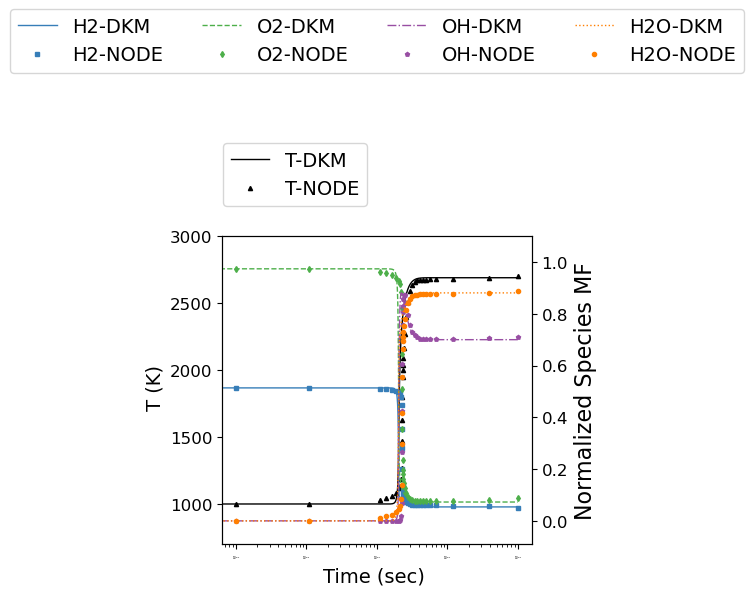

-----------start of simulation NN  8 --------------------------------------------------
Equivalence ration = 1.0, Temprature = 1100


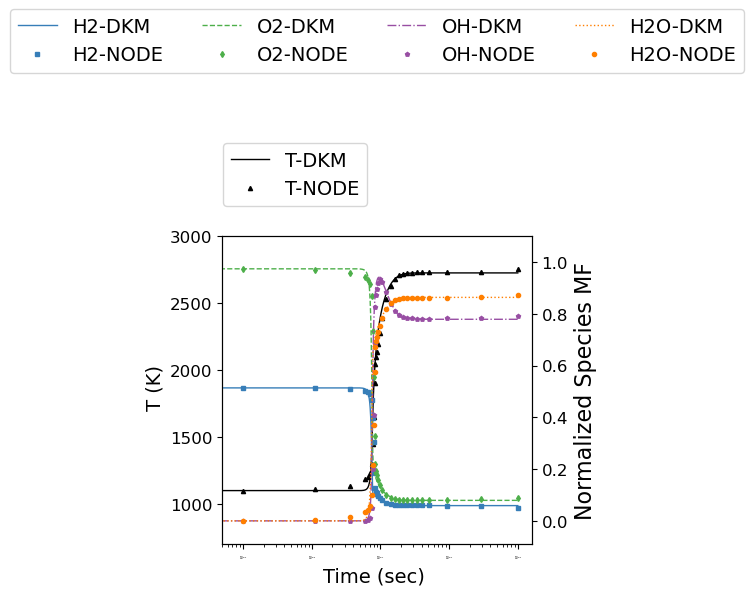

-----------start of simulation NN  9 --------------------------------------------------
Equivalence ration = 1.0, Temprature = 1050


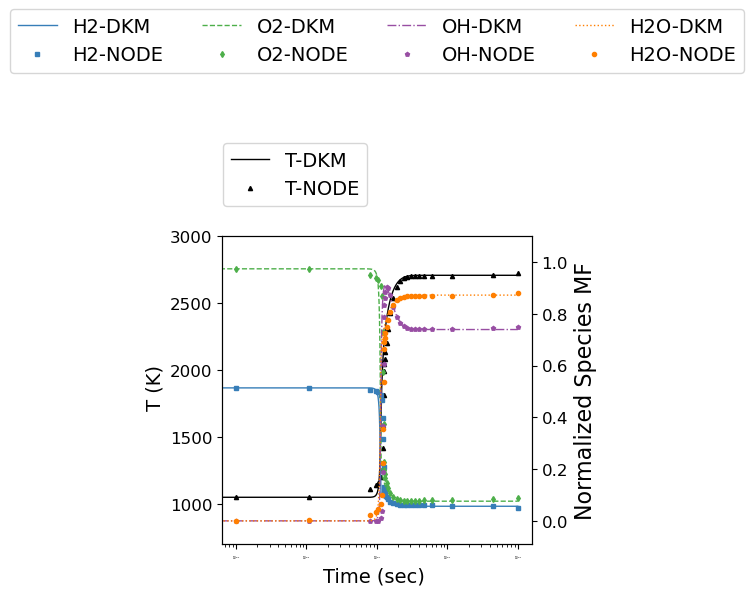

-----------start of simulation NN  10 --------------------------------------------------
Equivalence ration = 1.0, Temprature = 1150


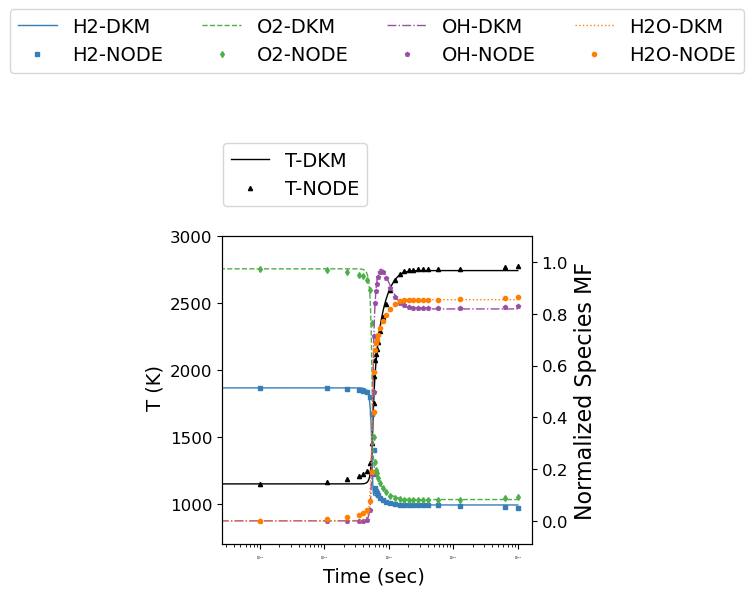

-----------start of simulation NN  11 --------------------------------------------------
Equivalence ration = 1.0, Temprature = 950


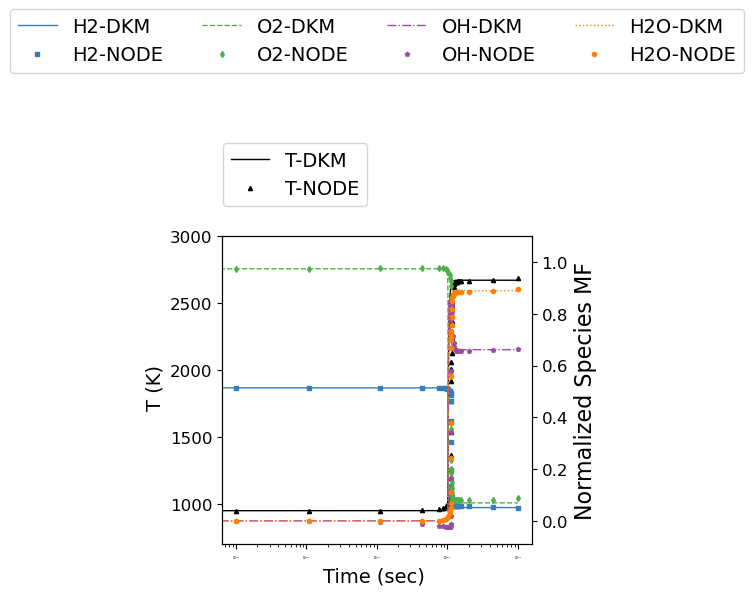

-----------start of simulation NN  7 --------------------------------------------------
Equivalence ration = 0.75, Temprature = 1200


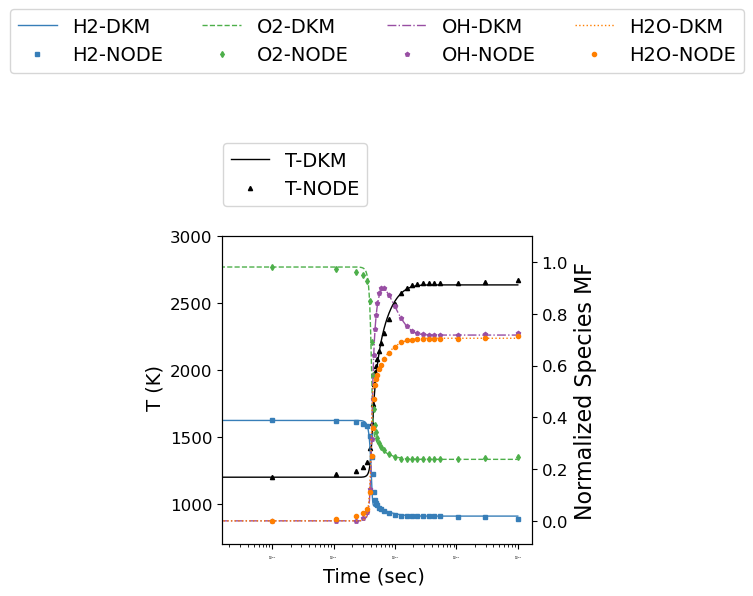

-----------start of simulation NN  8 --------------------------------------------------
Equivalence ration = 0.75, Temprature = 1000


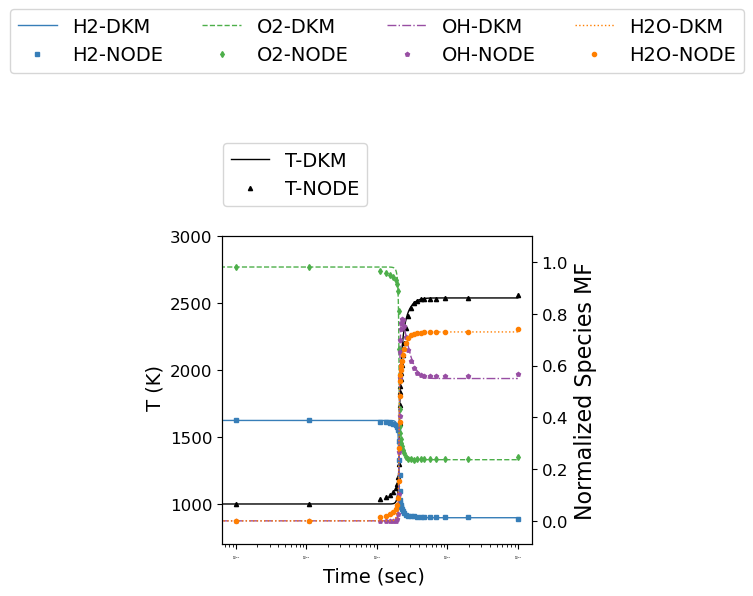

-----------start of simulation NN  9 --------------------------------------------------
Equivalence ration = 0.75, Temprature = 1100


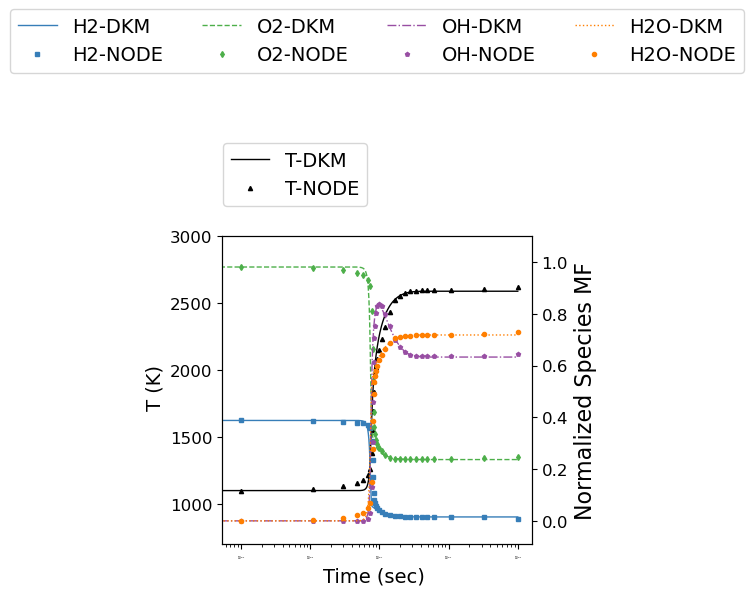

-----------start of simulation NN  10 --------------------------------------------------
Equivalence ration = 0.75, Temprature = 1050


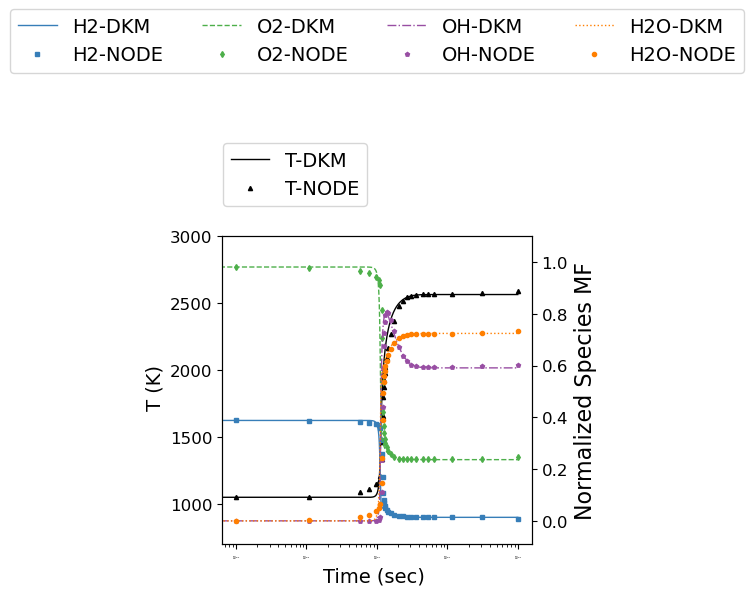

-----------start of simulation NN  11 --------------------------------------------------
Equivalence ration = 0.75, Temprature = 1150


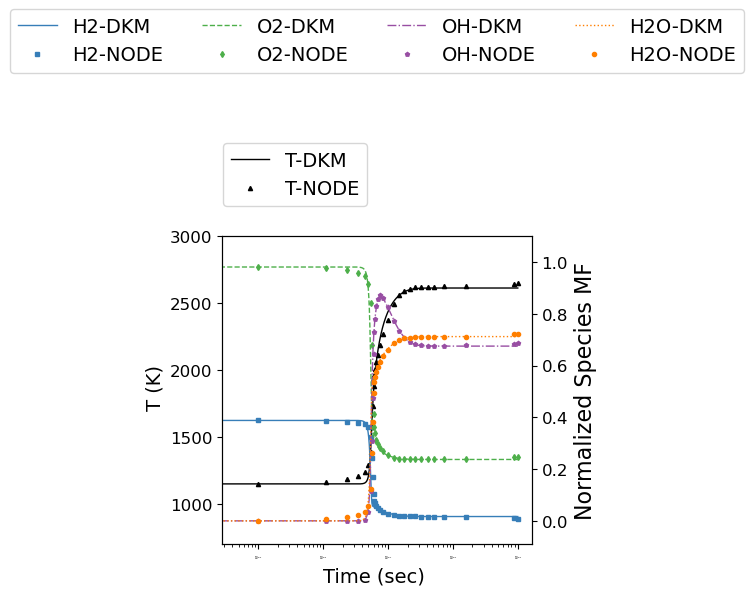

-----------start of simulation NN  12 --------------------------------------------------
Equivalence ration = 0.75, Temprature = 950


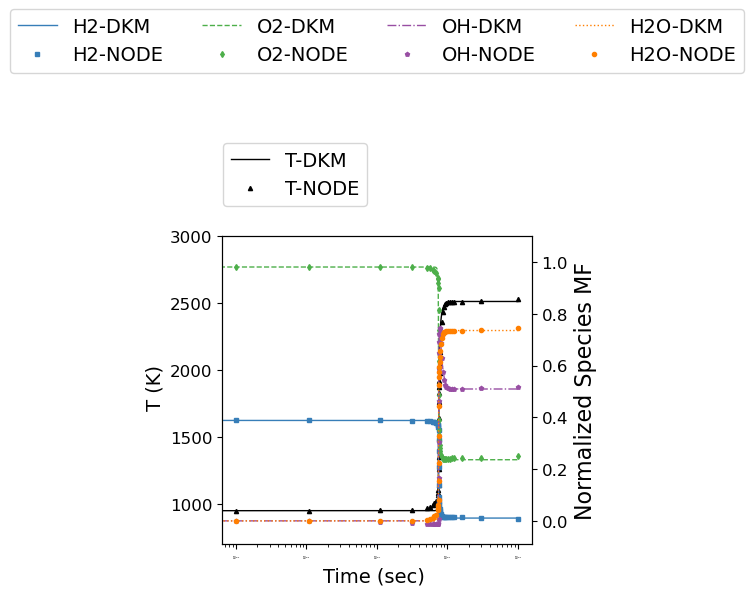

-----------start of simulation NN  8 --------------------------------------------------
Equivalence ration = 2.0, Temprature = 1200


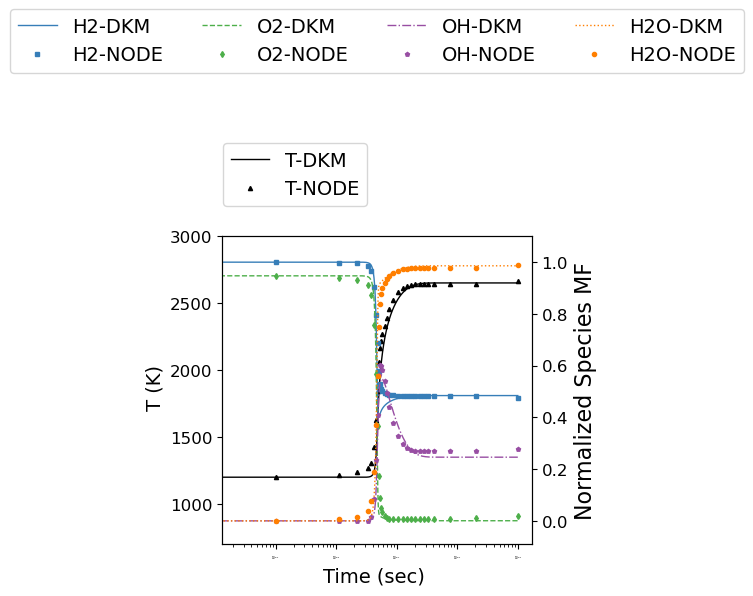

-----------start of simulation NN  9 --------------------------------------------------
Equivalence ration = 2.0, Temprature = 1000


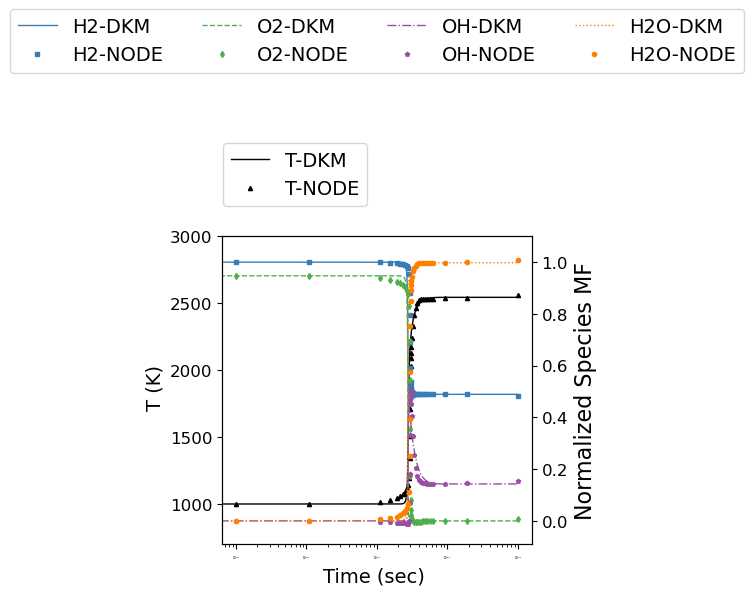

-----------start of simulation NN  10 --------------------------------------------------
Equivalence ration = 2.0, Temprature = 1100


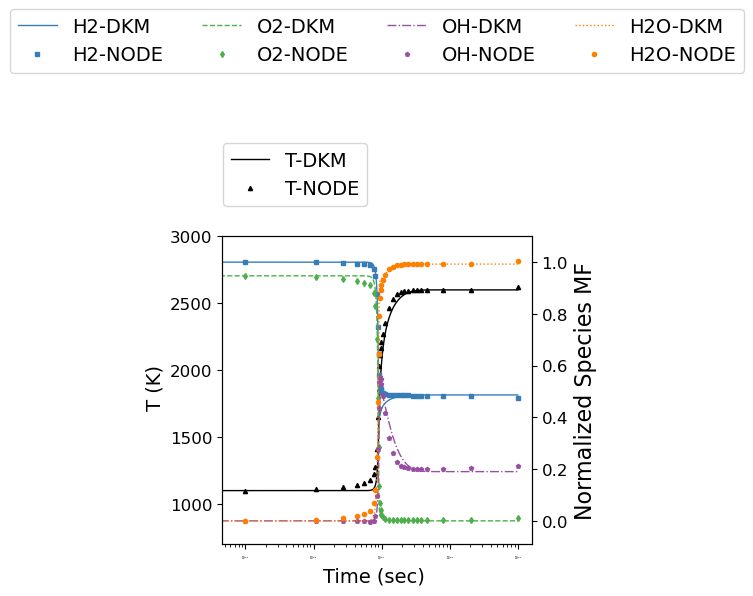

-----------start of simulation NN  11 --------------------------------------------------
Equivalence ration = 2.0, Temprature = 1050


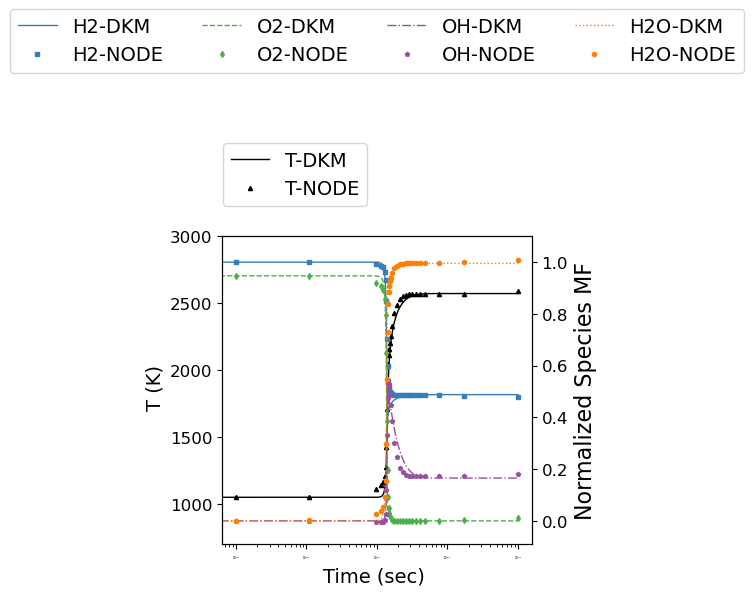

-----------start of simulation NN  12 --------------------------------------------------
Equivalence ration = 2.0, Temprature = 1150


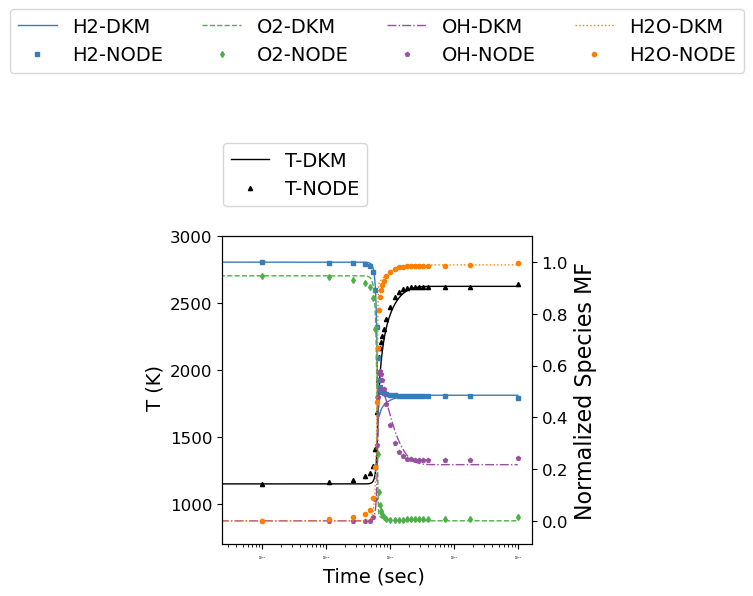

-----------start of simulation NN  13 --------------------------------------------------
Equivalence ration = 2.0, Temprature = 950


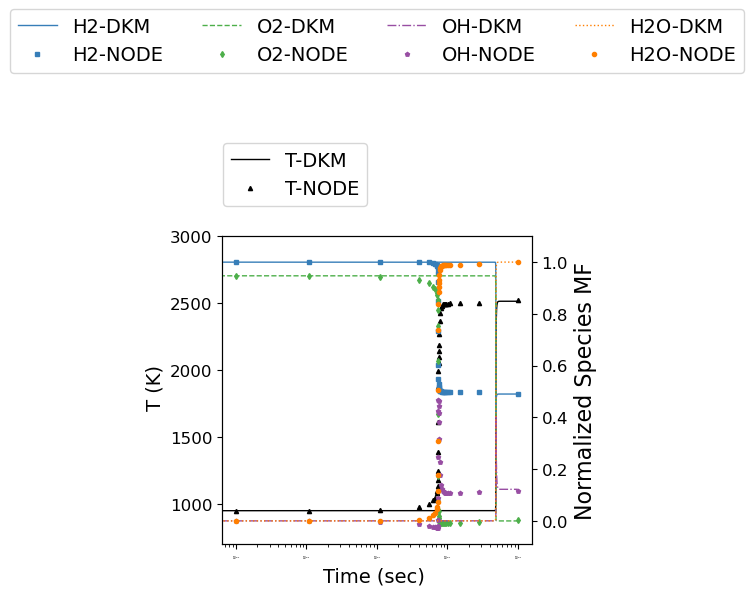

-----------start of simulation NN  9 --------------------------------------------------
Equivalence ration = 0.9, Temprature = 1200


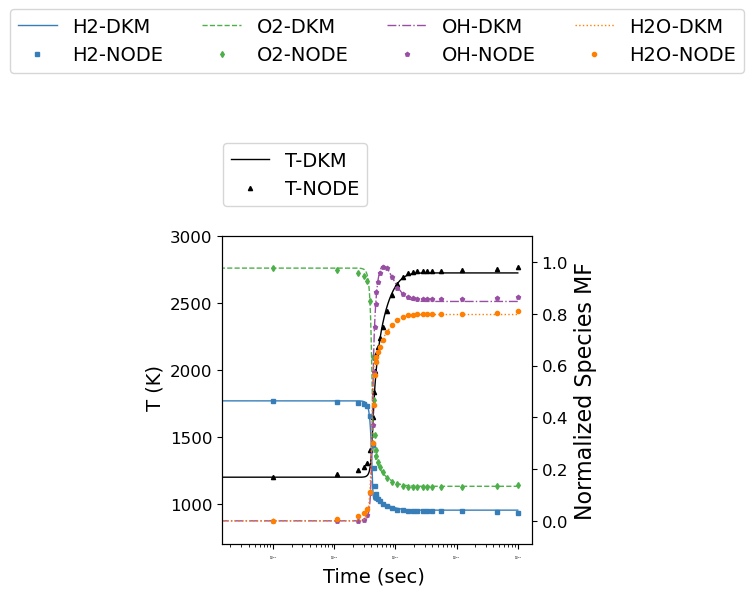

-----------start of simulation NN  10 --------------------------------------------------
Equivalence ration = 0.9, Temprature = 1000


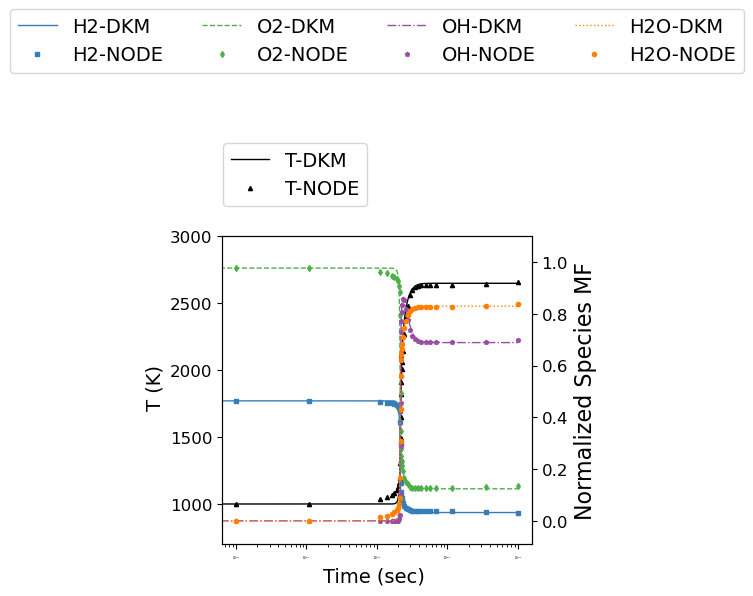

-----------start of simulation NN  11 --------------------------------------------------
Equivalence ration = 0.9, Temprature = 1100


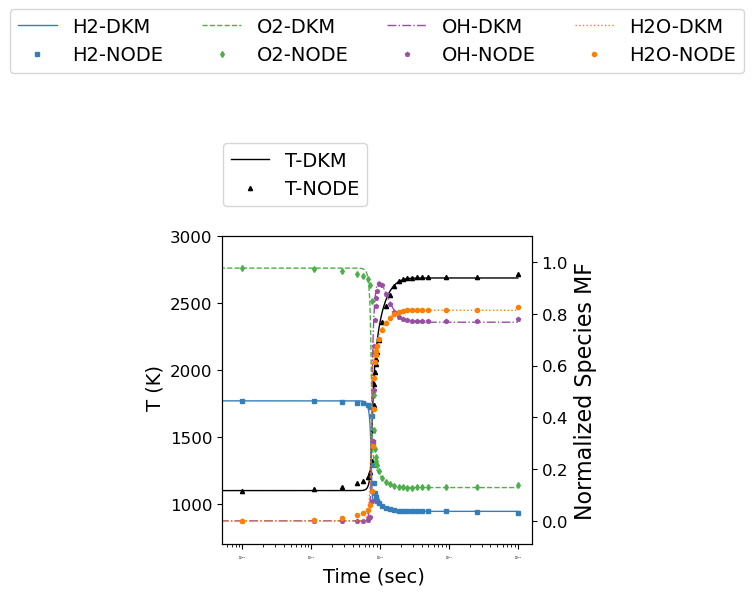

-----------start of simulation NN  12 --------------------------------------------------
Equivalence ration = 0.9, Temprature = 1050


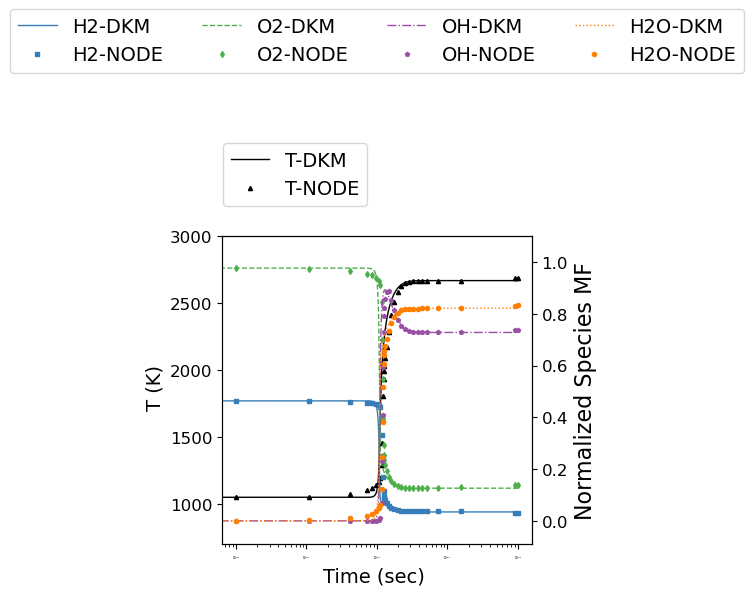

-----------start of simulation NN  13 --------------------------------------------------
Equivalence ration = 0.9, Temprature = 1150


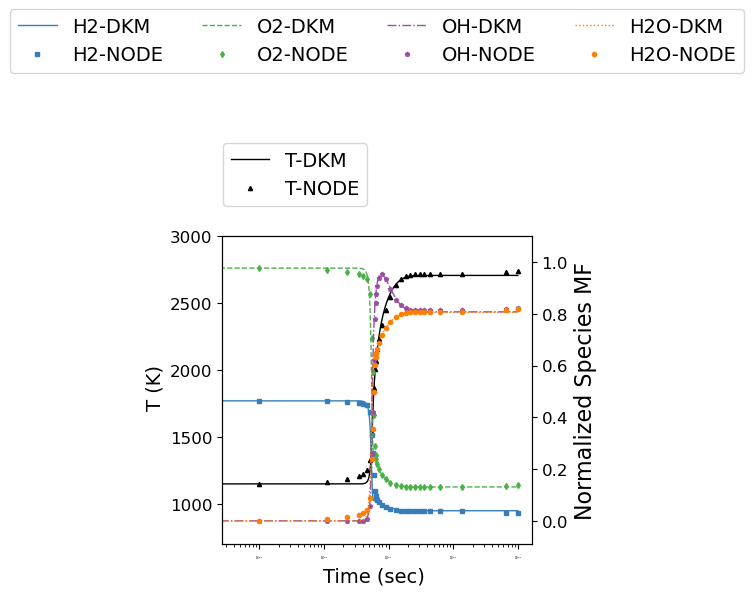

-----------start of simulation NN  14 --------------------------------------------------
Equivalence ration = 0.9, Temprature = 950


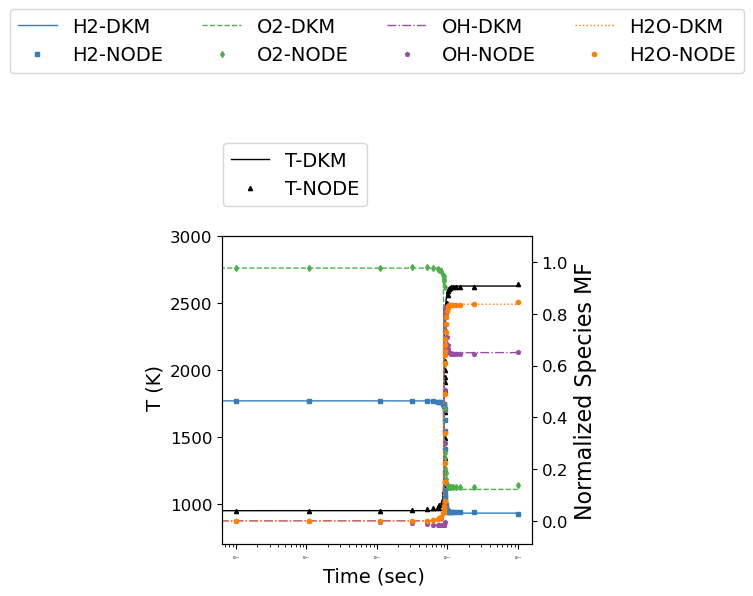

-----------start of simulation NN  10 --------------------------------------------------
Equivalence ration = 1.25, Temprature = 1200


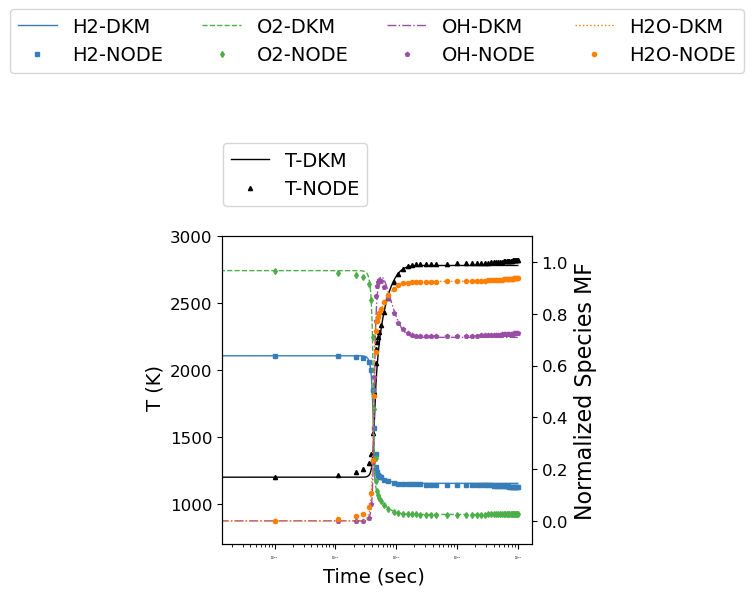

-----------start of simulation NN  11 --------------------------------------------------
Equivalence ration = 1.25, Temprature = 1000


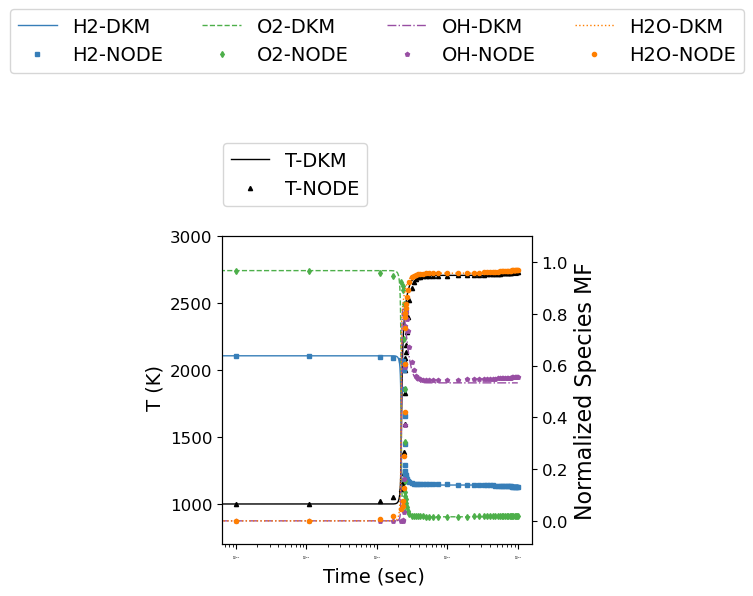

-----------start of simulation NN  12 --------------------------------------------------
Equivalence ration = 1.25, Temprature = 1100


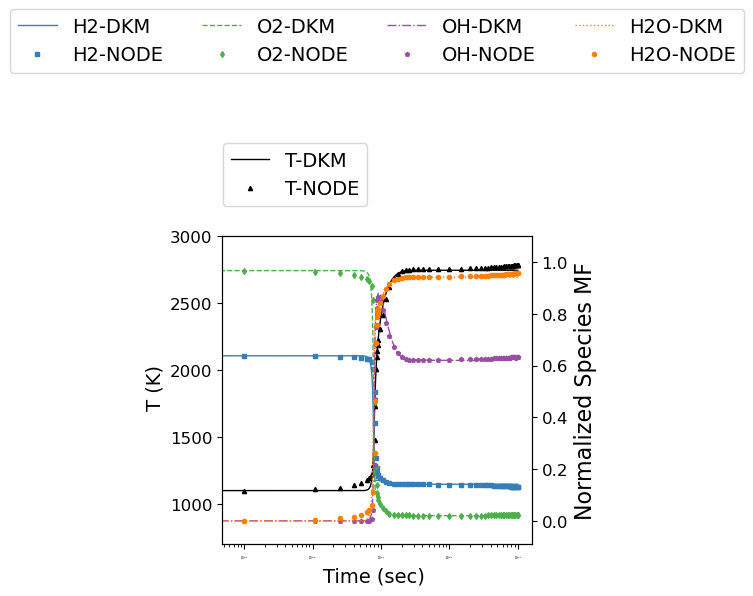

-----------start of simulation NN  13 --------------------------------------------------
Equivalence ration = 1.25, Temprature = 1050


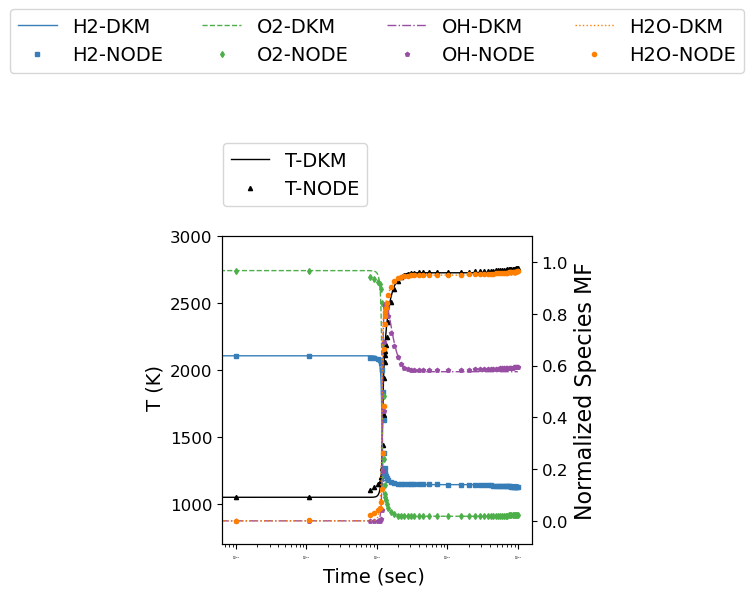

-----------start of simulation NN  14 --------------------------------------------------
Equivalence ration = 1.25, Temprature = 1150


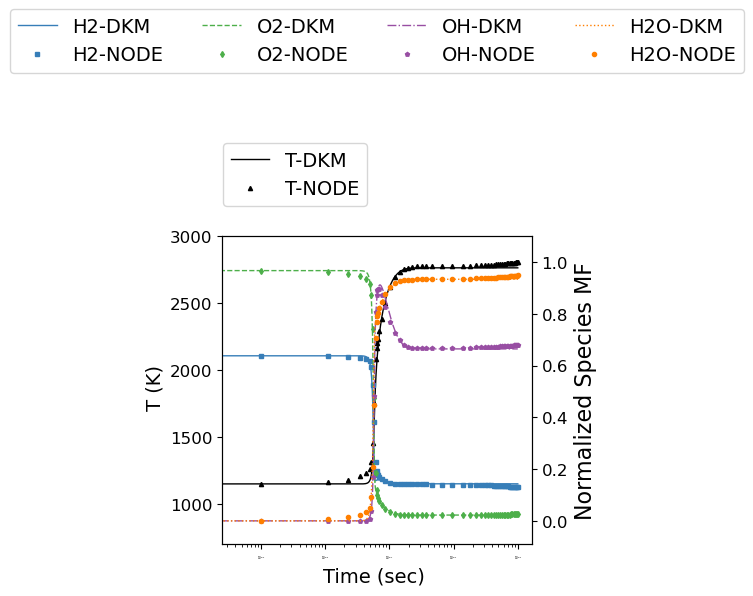

-----------start of simulation NN  15 --------------------------------------------------
Equivalence ration = 1.25, Temprature = 950


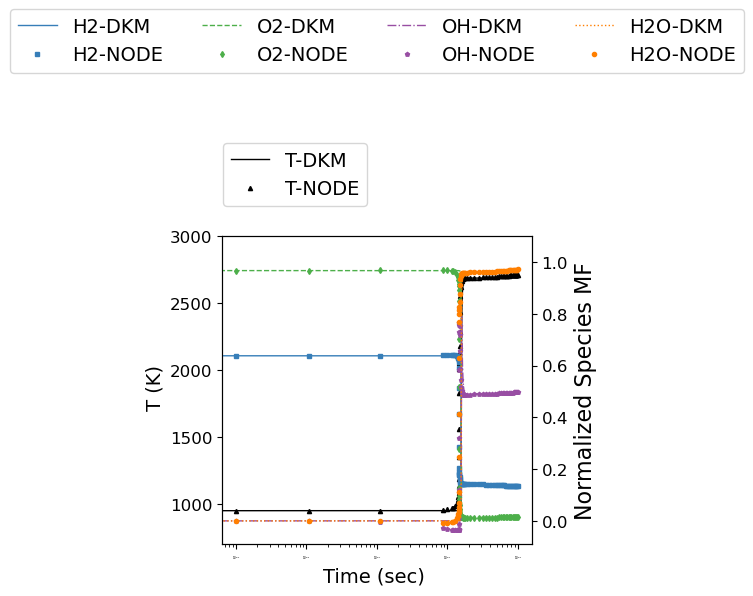

In [42]:
# eqr = [0.5,1.0,1.5]
# T0 = [950,1000]

sim_id = len(eqr)*len(T0)
for i in range(len(eqr)):
    for j in range(len(T0)):
        print(f'-----------start of simulation NN  {i+j+1} --------------------------------------------------')
        print(f'Equivalence ration = {eqr[i]}, Temprature = {T0[j]}')
        
        gas.set_equivalence_ratio(eqr[i], X1, X0)
        gas.TP = T0[j],P
        Yinit = gas.Y 
        hinit = gas.h  
        Tinit = gas.T
        Y0 = np.append(Yinit, Tinit)
        t = [0,tau_r]
#         tspan = np.logspace(-6,-2,100)
        a_tol = 1.0e-9*np.ones(nspecies+1)
        # a_tol[-1] = 1.0e-6
        yt_di = integrate.solve_ivp(Lambda(), t, Y0, method ='BDF',atol=a_tol, rtol=1.0e-7)      
        true_y = np.transpose(yt_di.y)
        t_id = yt_di.t
        
        Y0 = normalize(Y0)
        start = time.time()
        yt = integrate.solve_ivp(func, t, Y0,method ='RK45', atol=1.0e-5, rtol=1.0e-4,first_step = 1.0e-6)  
        end = time.time()
        
        norm_py_predict = np.transpose(yt.y)
        py_predict = denormalize(norm_py_predict)
        batch_t = yt.t
        
        filename = '01_phi_'+str(eqr[i])+'_T0_'+str(T0[j])
        
#         fig, ax = plt.subplots()  
        # Plots
        
#         plot_temp_compare(t_id,true_y,batch_t,py_predict,filename,ax)
        norm_tru_y = normalize(true_y)
        plot_tempOH_species(t_id,true_y,norm_tru_y,batch_t,py_predict,norm_py_predict,filename)
        
